# Red neuronal convolutiva: Dataset Boats

## Creación del modelo y entrenamientro

Para la primera parte de esta práctica vamos a crear y entrenar un modelo básico de una red neuronal, utilizando para ello el módulo de *Python Keras*.

### Comprobación del dataset: conexión a Drive y visualización del dataset

Primero vamos a montar el directorio de Drive en nuetro notebook.

In [0]:
# Conexión con Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


Una vez montado el directorio de Drive, comprobamos que tenemos todos los recursos disponibles para empezar a trabajar.

Primero listamos el contenido del directorio de muestras de test para ver que está disponible. Aquí podemos ver que nuestro dataset tiene 9 clases: boya, ferry, góndola, kayak, velero, barco de crucero, barco de carga, barco inflable y barco de papel.

Posteriormente, vemos que podemos acceder a las imágenes mostrando una de ellas.

Finalmente, comprobamos que estamos utilizando una GPU mediante la función *gpu_device_name* de *TensorFlow*.

 buoy	       'ferry boat'     gondola		   kayak	 sailboat
'cruise ship'  'freight boat'  'inflatable boat'  'paper boat'
/device:GPU:0


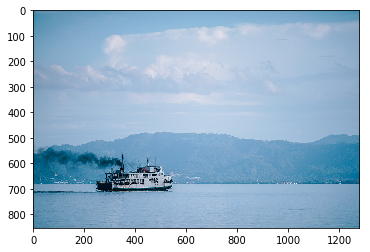

In [0]:
# Comprobación de imagenes
!ls '/content/drive/My Drive/Colaboratory/Practica2/dataset/boats/TEST'


from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image

%matplotlib inline
pil_im = Image.open('/content/drive/My Drive/Colaboratory/Practica2/dataset/boats/TEST/ferry boat/beach-beautiful-blue-boat-cruise-3741909.jpg', 'r')
imshow(np.asarray(pil_im))

# ¿Estamos usando una GPU?
import tensorflow as tf
print(tf.test.gpu_device_name())


## Preprocesado de las imágenes

Para preprocesar las imagenes utilizamos la clase *ImageDataGenerator* del módulo *preprocessing* de *Keras*, que genera imágenes a partir de pequeños cambios sobre las que nosotros aportamos en el dataset (reescalado, zoom, voltear, etc).

Una vez creadas los generadores de imagenes, cargamos las imagenes del dataset a partir del directorio donde hemos subido previamente las imagenes. Estas deben estar separadas por categorias en carpetas, donde cada una es una categoria.


In [0]:
from keras.preprocessing.image import ImageDataGenerator

train_data_dir = '/content/drive/My Drive/Colaboratory/Practica2/dataset/boats/TRAIN'
validation_data_dir = '/content/drive/My Drive/Colaboratory/Practica2/dataset/boats/TEST'

train_datagen = ImageDataGenerator(
        rescale=1./255, # Factor de reescalado
        shear_range=0.2, # Giro de imagen
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

batch_size_train = 20
batch_size_validate = 32

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(200, 200), # Reescalado de la imagen a tamaño igualado
        batch_size=batch_size_train, # Ajuste del tamaño de los batches
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(200, 200),
        batch_size=batch_size_validate,
        class_mode='categorical')

Using TensorFlow backend.


Found 1095 images belonging to 9 classes.
Found 368 images belonging to 9 classes.


## Diseño del modelo

El modelo de nuestra red neuronal contendrá las siguientes capas:


* Convolutiva: obtiene detalles de las imagenes —como bordes, profundidad, etc—, mediante la aplicación de una operación convolutiva por cada filtro de la capa convolutiva.

* MaxPooling: divide la imagen en una cuadrícula de pixeles de 2x2 y toma, de cada celda, el valor del pixel de mayor valor.

* Dropout: pone a cero una proporción de pixeles elegidos aleatoriamentes.

* Flatten: convierte el tensor resultado de las capas previas en un vector.

* Dense: red de neuronal full-connected que recibe como entrada el vector resultado de la capa Flatten. Se encarga de, en conjunto de la función de activación—que normaliza el valor entre 0 y 1—, de calcular una serie de pesos, que permiten predecir la probabilidad de que la muestra introducida sea una de las clases. 



In [0]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
import keras

model = Sequential()
model.add(Conv2D(64, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(200, 200, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(9, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


## Entrenamiento básico

In [0]:
epochs = 10

model.fit_generator(
        train_generator,
        steps_per_epoch=100,
        epochs=epochs, 
        validation_data=validation_generator,
        validation_steps=800,
)


Epoch 1/10
100/100 [==============================] - 491s 5s/step - loss: 0.5575 - acc: 0.8145 - val_loss: 1.9964 - val_acc: 0.5786
Epoch 2/10
100/100 [==============================] - 487s 5s/step - loss: 0.4916 - acc: 0.8407 - val_loss: 2.0403 - val_acc: 0.5521
Epoch 3/10
100/100 [==============================] - 488s 5s/step - loss: 0.4524 - acc: 0.8495 - val_loss: 1.9827 - val_acc: 0.5786
Epoch 4/10
100/100 [==============================] - 485s 5s/step - loss: 0.3935 - acc: 0.8648 - val_loss: 2.1948 - val_acc: 0.5950
Epoch 5/10
100/100 [==============================] - 495s 5s/step - loss: 0.3699 - acc: 0.8792 - val_loss: 2.1114 - val_acc: 0.5791
Epoch 6/10
100/100 [==============================] - 490s 5s/step - loss: 0.3117 - acc: 0.9038 - val_loss: 2.4761 - val_acc: 0.5759
Epoch 7/10
100/100 [==============================] - 489s 5s/step - loss: 0.2644 - acc: 0.9080 - val_loss: 2.4623 - val_acc: 0.5731
Epoch 8/10
100/100 [==============================] - 492s 5s/step - 